# Optimized soil sampling

<left><img src="images/soil_sampling_optimization.png" width="500px" align="right"/>
    
Soil sampling is crucial for understanding soil properties and estimating factors like erosion, moisture and fertility. However, selecting representative sampling locations can be costly due to the high number of samples and challenging due to varying terrain characteristics. Soil sampling optimization refers to the process of designing and implementing a sampling strategy that efficiently collects soil data to **accurately represent the properties and variability of a given area while minimizing effort, cost, or resources**. The goal is to determine the best locations, number, and distribution of soil samples to capture key characteristics such as fertility, moisture content, pH, nutrient levels, or erosion loss rates across a landscape that vary due to factors like topography, land use, or soil type.

This notebook explains and demonstrates a **stratified sampling** approach that optimally allocates sampling, ensuring a balanced representation of terrain variability.

### What is Stratified Sampling?
Stratified sampling is a statistical method used to improve the representativeness of a sample by dividing a population into distinct subgroups, or *strata*, based on specific characteristics, in this case, terrain features like slope and flow accumulation. Instead of randomly selecting points across the entire study area and allocates sampling points proportionally within each stratum. This ensures both common and rare terrain conditions are adequately represented.

### Why Use Stratified Sampling?
✅ Captures **dominant terrain conditions** effectively while preserving **landscape variability**.

✅ Improves the accuracy of soil property estimates across heterogeneous areas.

### Methodology Overview
- **Load Terrain Data**: Import Digital Elevation Model (DEM), slope, and flow accumulation raster data.
- **Define Strata**: Establish stratification classes using percentile thresholds for slope and flow accumulation.
- **Allocate Samples**: Distribute sampling points proportionally to strata frequency, ensuring rare conditions are included.
- **Select Points**: Randomly choose sampling locations within each stratum.
- **Export & Visualize**: Save sampled coordinates and display them on a map.
- **Interactive Tool**: Provide a widget to adjust sampling parameters dynamically.

In [1]:
import os
import numpy as np
import rasterio
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown
from iMPACTools.file_IO import load_raster, open_raster
from iMPACTools.optimized_sampling import plot_histograms,stratified_sampling

## Choose the case study

In [2]:
# Get list of case studies (folders in the Case_studies directory)
case_study = Dropdown(options=os.listdir('../Case_studies'),description='Case Study:')
display(case_study)  

Dropdown(description='Case Study:', options=('Montefrio', 'SantaCruz'), value='Montefrio')

### Load the DEM, slope, and flow accumulation rasters

In [19]:
# Load raster data (Digital Elevation Model, Slope, Flow Accumulation)
dem, metadata = open_raster(f'../Case_studies/{case_study.value}/topo/','dem_catchment.tif')
slope, _ = open_raster(f'../Case_studies/{case_study.value}/topo/','slope.tif')
flow_acc, _ = open_raster(f'../Case_studies/{case_study.value}/flow/','flow_acc_D8.tif')

transform = metadata['transform']
crs = metadata['crs']

#### Mask the stream network in the flow accumulation map (optional)

In [21]:
stream_mask, _ = open_raster(f'../Case_studies/{case_study.value}/flow/','stream_mask_D8.tif')
flow_acc[np.isnan(stream_mask)] = np.nan

#### Remove invalid gridcells

In [23]:
# Flatten raster arrays and remove NaN values (invalid pixels/gridcells)
valid_mask = ~np.isnan(slope) & ~np.isnan(flow_acc)
slope_values = slope[valid_mask]
flow_acc_values = flow_acc[valid_mask]

### Define stratification classes

In [24]:
num_classes = 3 # Adjust the number of classes if needed

# Compute percentile-based classes for stratification
slope_classes = np.percentile(slope_values, np.arange(100 / num_classes, 100, 100/num_classes))
flow_acc_classes = np.percentile(flow_acc_values, np.arange(100 / num_classes, 100, 100/num_classes))

# Assign each gridcell to a stratified class
slope_grid_classes = np.digitize(slope_values, slope_classes, right=True)
flow_acc_grid_classes = np.digitize(flow_acc_values, flow_acc_classes, right=True)

#### Interactive visualization of stratification classes

In [26]:
def interactive_plot(dataset):
    """Interactive visualization of histogram and spatial distribution of classes."""
    # Select values and bins based on user selection
    if dataset == "Slope":
        grid, values, classes, grid_classes = slope, slope_values, slope_classes, slope_grid_classes
    elif dataset == "Flow Accumulation":
        grid, values, classes, grid_classes = flow_acc, flow_acc_values, flow_acc_classes, flow_acc_grid_classes
        
    # Create a figure with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot histograms with stratification bins
    axes[0].hist(values, bins=50, edgecolor='black', alpha=0.7)
    for class_edge in classes:
        axes[0].axvline(class_edge, color='red', linestyle='dashed', linewidth=1)
    axes[0].set_title("Histogram and Stratification Bins")
    axes[0].set_xlabel("Value")
    axes[0].set_ylabel("Frequency")
    
    # Plot classified raster
    grid[~valid_mask] = np.nan
    grid[valid_mask] = grid_classes
    # Plot imshow on the right
    raster_plot = axes[1].imshow(grid, cmap="viridis")  # Use colormap for better visualization
    fig.colorbar(raster_plot, ax=axes[1])  # Add colorbar to the image plot
    axes[1].set_title("Spatial Distribution of classes")

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()
    
interact(interactive_plot, dataset=["Slope", "Flow Accumulation"])

interactive(children=(Dropdown(description='dataset', options=('Slope', 'Flow Accumulation'), value='Slope'), …

<function __main__.interactive_plot(dataset)>

### Define Sampling Strategy
Selects sampling points proportionally to the frequency of each category.

In [27]:
# Create unique strata based on slope and flow accumulation combinations
strata_labels = slope_grid_classes * 10 + flow_acc_grid_classes  # Unique class labels. The multiplication by 10, 100, ... 
# ensures that each combination gets a unique identifier. 
unique_strata, strata_counts = np.unique(strata_labels, return_counts=True)

# Define number of samples proportionally to strata frequency
num_samples = 30  # Adjust based on study area needs
strata_proportions = strata_counts / strata_counts.sum()
samples_per_stratum = (strata_proportions * num_samples).round().astype(int)

# Select random samples from each stratum
sample_indices = []
for strata, count in zip(unique_strata, samples_per_stratum):
    indices = np.where(strata_labels == strata)[0]
    if len(indices) > 0:
        selected = np.random.choice(indices, min(count, len(indices)), replace=False)
        sample_indices.extend(selected)

# Convert pixel indices back to coordinates
row_indices, col_indices = np.where(valid_mask)
selected_rows = row_indices[sample_indices]
selected_cols = col_indices[sample_indices]

# Convert pixel coordinates to geographic coordinates
selected_coords = [
    (transform * (col, row)) for row, col in zip(selected_rows, selected_cols)]
print("Sampling complete.")

Sampling complete.


### Visualize Sampling Points

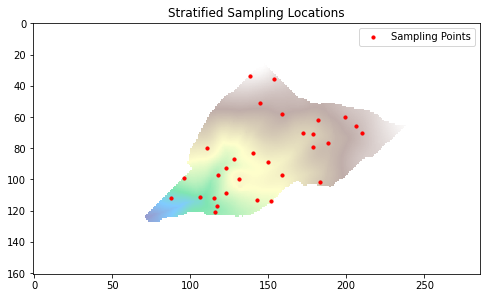

Sampling complete. Points saved to 'stratified_sampling_points.csv'.


In [28]:
# Save sampled points as CSV
df_samples = pd.DataFrame(selected_coords, columns=["Longitude", "Latitude"])
df_samples.to_csv("stratified_sampling_points.csv", index=False)

# Plot sample locations on DEM background
plt.figure(figsize=(8, 6))
plt.imshow(dem, cmap="terrain", alpha=0.5)
plt.scatter(selected_cols, selected_rows, color="red", s=10, label="Sampling Points")
plt.legend()
plt.title("Stratified Sampling Locations")
plt.show()

print("Sampling complete. Points saved to 'stratified_sampling_points.csv'.")

### Let's do it more interactive!

In [31]:
# Define file paths for the raster data (DEM slope and flow accumulation)
raster_paths = {"Slope": "inputs/slope_catchment_dem.tif", "Flow_Acc": "inputs/flow_acc_D8_catchment_dem_masked_stream.tif"}

# Initialize a dictionary to store the loaded raster data and other necessary variables
raster_dict = {}
transform, crs = None, None

# Load raster data (slope and flow accumulation) into the dictionary
for key, path in raster_paths.items():
    raster, transform, crs = load_raster(path) # Load raster and extract transform, crs
    raster_dict[key] = raster # Store the loaded raster in the dictionary under the corresponding key

def interactive_sampling(num_classes=3, num_samples=30):
    """
    Function to perform stratified sampling and display the results interactively.
    - num_classes: Number of classes for stratification.
    - num_samples: Number of sampling points to select.
    """
    
    # Perform stratified sampling and get total samples, selected coordinates, and their row/column indices
    # This function also plots histograms with stratification bins
    total_samples, selected_coords, selected_cols, selected_rows = stratified_sampling(
        raster_dict, transform, num_classes, num_samples)
    
    # Plot the DEM and mark the sampling locations on the map
    plt.figure(figsize=(8, 5))
    plt.imshow(dem, cmap="terrain", alpha=0.5) # Display the DEM
    plt.scatter(selected_cols, selected_rows, color="red", s=10, label="Sampling Points") # Plot sampling points
    plt.legend()
    plt.title(f"Stratified Sampling Locations (Classes = {num_classes}, Samples = {total_samples})")
    plt.show()
    
    # Convert selected coordinates to a DataFrame and save to CSV
    df_samples = pd.DataFrame(selected_coords, columns=["X", "Y"])
    df_samples.to_excel(f'../Case_studies/{case_study.value}/sampling/optimal_sampling_points.xlsx', index=False)

# Create interactive widget
interact(interactive_sampling, num_classes=(2, 10, 1), num_samples=(10, 100, 10))

interactive(children=(IntSlider(value=3, description='num_classes', max=10, min=2), IntSlider(value=30, descri…

<function __main__.interactive_sampling(num_classes=3, num_samples=30)>